In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from astropy.io import ascii
from astropy.table import Table, Column, MaskedColumn
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.coordinates import BarycentricMeanEcliptic

import healpy as hp

In [2]:
# Import the coordinates of the verification binaries

rawdata = ascii.read("verbinaries_data_wsource_name.txt")

params = ['lGal', 'bGal', 'orbital_period', 'm1', 'm1e', 'm2', 'm2e', 'i', 'freq', 'par','epar', 'dis', 'edis', 'A', 'eA', 'SNR', 'eSNR']
# units: lGal [deg], bGal [deg], orbital_period [s], m1 [Msol], m1e [Msol], m2 [Msol], m2e [Msol]
# i [deg], freq (of gws) [mHz], par [mas], epar [mas], dis [pc], edis [pc], A [1e-23], eA [1e-23], SNR, eSNR

sourcenames = np.array(rawdata["source"])

galactic_longitude = np.array(rawdata["lGal"])  # degree range from [0,360]
galactic_latitude = np.array(rawdata["bGal"])  # degree range from [-90,90]

# Transform coordinates to (barycentric mean) ecliptic coordinates
gc = SkyCoord(l=galactic_longitude*u.degree, b=galactic_latitude*u.degree, frame='galactic')
gw_beta_true = np.deg2rad(gc.barycentricmeanecliptic.lon.value) # degree to rad range [0,2pi]
gw_lambda_true = np.deg2rad(gc.barycentricmeanecliptic.lat.value) # degree to rad range [-pi/2,pi/2]

# Transform coordinates to equatoral (ICRS) coordinates
ra = gc.icrs.ra.value # degree range [0,360]
dec = gc.icrs.dec.value # degree range [-90,90]

Ngalbins = len(sourcenames)

In [3]:
# Plot Galactic plane to recreate figure from T. Kupfer et al.
n = 100
gc_gp_lat, gc_gp_lon = np.zeros(n),np.linspace(0,360,n) # in galactic coordinates

# print (gc_gp_lat, gc_gp_lon)

# Transform from Galactic to (barycentric mean) ecliptic coordinates
gc2 = SkyCoord(l=gc_gp_lon*u.degree, b=gc_gp_lat*u.degree, frame='galactic')
gp_beta = gc2.barycentricmeanecliptic.lon.value # degree range [0,360]
gp_lambda = gc2.barycentricmeanecliptic.lat.value # degree range [-90,90]

# print (gp_beta,gp_lambda)

# Transform coordinates to equatoral (ICRS) coordinates
gp_ra = gc2.icrs.ra.value # degree range [0,360]
gp_dec = gc2.icrs.dec.value # degree range [-90,90]

# print (gp_ra,gp_dec)

# Center of galactic plane [Gal_coords, Ecliptic_coords, Equatoral_coords]
gpct = np.array([[gc_gp_lon[0],gc_gp_lat[0]],[gp_beta[0],gp_lambda[0]],[gp_ra[0],gp_dec[0]]])

In [4]:
def hp_transform(lat):
    # Transform a [-pi/2,pi/2] range to -[-pi,0] range
    return np.pi/2 - lat

NSIDE = 32
print(
    "Approximate resolution at NSIDE {} is {:.2} deg".format(
        NSIDE, hp.nside2resol(NSIDE, arcmin=True) / 60
    )
)
NPIX = hp.nside2npix(NSIDE)

Approximate resolution at NSIDE 32 is 1.8 deg


/home/bart/Desktop/lisa/venv-lisa/lib/python3.8/site-packages/healpy/projaxes.py:202: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  aximg = self.imshow(
/home/bart/Desktop/lisa/venv-lisa/lib/python3.8/site-packages/healpy/projaxes.py:541: UserWarning: 0.0 180.0 -180.0 180.0
  warnings.warn(
/home/bart/Desktop/lisa/venv-lisa/lib/python3.8/site-packages/healpy/projaxes.py:656: UserWarning: The interval between parallels is 30 deg -0.00'.
  warnings.warn(
/home/bart/Desktop/lisa/venv-lisa/lib/python3.8/site-packages/healpy/projaxes.py:664: UserWarning: The interval between meridians is 30 deg -0.00'.
  warnings.warn(


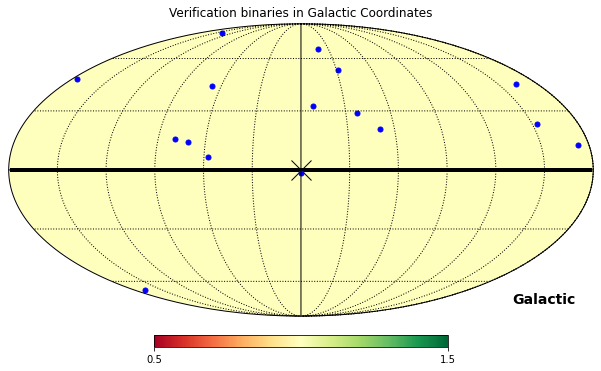

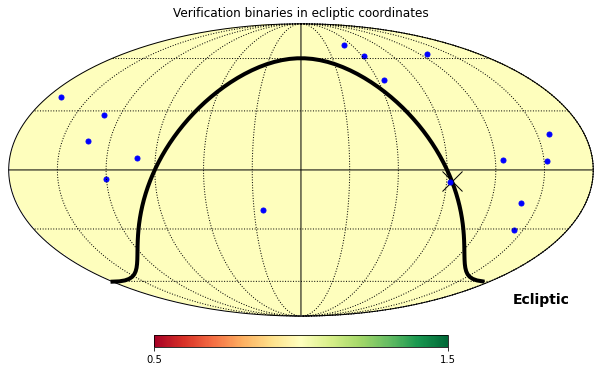

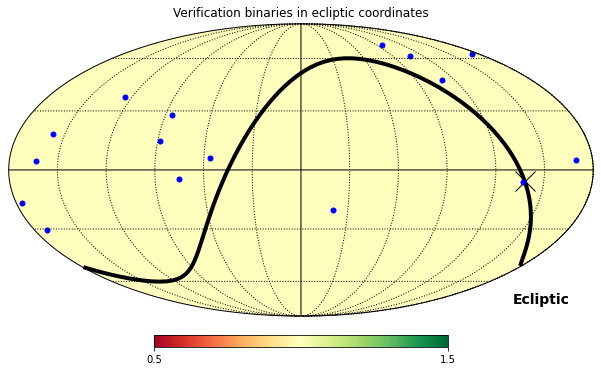

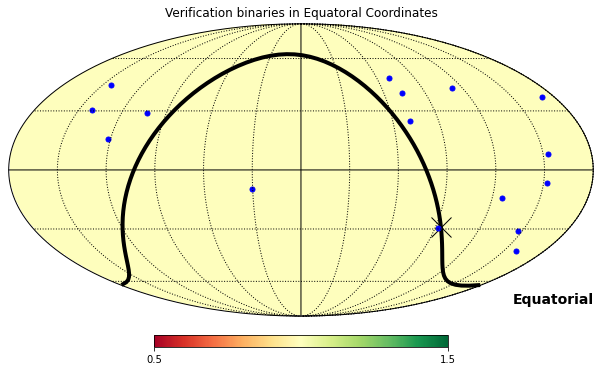

In [5]:
sky_rotation = 45 # degrees rotation in longitude direction

def mollviewplot(m,lon_gp, lat_gp, lon_bin, lat_bin, galcenter, coordsys, title, skyrot=0):
    hp.mollview(m, title=title,cmap=plt.get_cmap("RdYlGn"), min=0.5,max=1.5, coord=coordsys)
    hp.projplot(hp_transform(np.deg2rad(lat_gp)), np.deg2rad(lon_gp-skyrot),linestyle='-',c='black',linewidth=4)
    hp.projplot(hp_transform(np.deg2rad(galcenter[1])), np.deg2rad(galcenter[0]-skyrot), marker="x",color='black',markersize=20)
    hp.projplot(hp_transform(np.deg2rad(lat_bin)), np.deg2rad(lon_bin-skyrot), linestyle='',marker="o", color="Blue", markersize=5)
    hp.graticule(dpar=30,dmer=30,coord=coordsys)

m = np.ones(NPIX)

# Galactic coordinates
mollviewplot(m,gc_gp_lon,gc_gp_lat,galactic_longitude,galactic_latitude,gpct[0],'G',"Verification binaries in Galactic Coordinates")

# Ecliptic coordinates
mollviewplot(m,gp_beta,gp_lambda,np.rad2deg(gw_beta_true),np.rad2deg(gw_lambda_true),gpct[1],'E',"Verification binaries in ecliptic coordinates")
mollviewplot(m,gp_beta,gp_lambda,np.rad2deg(gw_beta_true),np.rad2deg(gw_lambda_true),gpct[1],'E',"Verification binaries in ecliptic coordinates",sky_rotation)




# # Equatoral coordinates
mollviewplot(m,gp_ra,gp_dec,ra,dec,gpct[2],'C',"Verification binaries in Equatoral Coordinates")



# Since we're nearly there, let's plot the sensitifity on the sky as a background

In [6]:
## Code from Oliver
from numpy import *

alpha = radians(60)  # found somewhere in code, sometimes alpha is pi/6, however...

def toOrbit(X,Y,Z, psi=0, a=0, xi=0):
    '''
    Converts 'canonical coordinates' (i.e. centered on the origin and along the standard directions)
    into 'orbit coordinates'
    
    Parameters
    ----------
    
    X,Y,Z  : canonical coordinates
    psi    : internal rotation of the constellation
    a      : orbital radius
    xi     : position on the orbit
    
    For LISA, psi=-xi, as the constellation counterrotates
    '''
    
    xp = (cos(xi)*(2*a - Z + sqrt(3)*X*cos(psi) - sqrt(3)*Y*sin(psi)))/2. - (Y*cos(psi) + X*sin(psi))*sin(xi)
    yp = cos(xi)*(Y*cos(psi) + X*sin(psi)) + ((2*a - Z + sqrt(3)*X*cos(psi) - sqrt(3)*Y*sin(psi))*sin(xi))/2.    
    zp = (sqrt(3)*Z + X*cos(psi) - Y*sin(psi))/2.
    
    return xp,yp,zp

def twoarm( theta, phi, alpha=pi/6):
    return sin(2*alpha)*sqrt( 4*cos(theta)**2*cos(2*phi)**2 + (1+cos(theta)**2)**2*sin(2*phi)**2)

def twoarmpol( theta, phi, chi, alpha=pi/6):
    u = cos(theta)
    return sin(2*alpha)*( (u^2+1)*cos(2*chi)*sin(2*phi)-2*u*sin(2*chi)*cos(2*phi) )

def pathOfSource(Theta, Phi, plain=True, xi=0, a=0, e=1, tau=[]):
    """
    Calculates the path of the source in the detector system for one orbital period (i.e. one year)

    Parameters
    ----------

    Theta     : Theta-coordinate of the source in solar system coordinates
    xi        : Initial orientation of the constellation
    e         : Tilt of the constellation: e=+1 is up, e=-1 is down
    tau       : orbital parameter. If not set, 0 to 2pi will be taken
    plain     : Defaults to True. If false, the path will be plot on the tumbling pattern.
                In this case, xi and a need to be set as well
    a         : orbital radius
    xi        : orbital phase

    """
    
    
    if len(tau)==0:
        tau = np.linspace(0, 2 * np.pi, 100)

    psi= -e*xi
    
    # calculate the path 
    x = 1/4*sin(Theta)*( (sqrt(3)-2*e)*cos(2*tau-Phi)+(sqrt(3)+2*e)*cos(Phi)) + 1/2*e*cos(Theta)*cos(tau)
    
    y = 1/4*sin(Theta)*( (e*sqrt(3)-2)*sin(2*tau-Phi)+(e*sqrt(3)+2)*sin(Phi)) + 1/2*cos(Theta)*sin(tau)
    
    z = 1/2*(sqrt(3)*cos(Theta) - e*sin(Theta)*cos(tau-Phi))
    
    

    # get the two angles now in the detector system
    phi = arctan2(y, x)
    theta = arccos(z)

    # this is the easiest way
    r  = twoarm(theta,phi)
    rx = r*x
    ry = r*y
    rz = r*z

    # take care of the orbital motion, if needed
    if not plain:
        rx,ry,rz = toOrbit(rx,ry,rz,psi=psi,a=a,xi=xi)
        
    return rx, ry, rz,r, phi, theta, tau

def DetectorPosFromSkyPos(Theta, Phi, xi=0, Psi=0, up=True ):
    
    if up:
        e=1
    else:
        e=-1
        
    rx, ry, rz, r, phi, theta, tau = pathOfSource( Theta, Phi, Psi, xi, e)
    #tau = np.linspace(0, 2 * np.pi, 100)
    
    
    #x = 1/4*( sin(Theta)*(-(2-e*sqrt(3))*cos(xi+Phi-Psi-(1+e)*tau)+(2+e*sqrt(3))*cos(xi-Phi+Psi+(1-e)*tau)) - 2*cos(Theta)*cos(xi-e*tau))
    #y = 1/4*( sin(Theta)*( (2-e*sqrt(3))*sin(xi+Phi-Psi-(1+e)*tau)-(2+e*sqrt(3))*sin(xi-Phi+Psi+(1-e)*tau)) + 2*cos(Theta)*sin(xi-e*tau))
    #z = 1/2*( sin(Theta)*cos(Phi-Psi-tau)+ e*sqrt(3)*cos(Theta))

    ## get the angles
    #phi = arctan2(y,x)
    #theta = arccos(z)
    
    return phi,theta, tau
    
    
def SignalFromSkyPos( Theta, Phi, xi=0, Psi=0, up=True):
   
    
    (PHI, THETA, tau)= DetectorPosFromSkyPos( Theta, Phi, xi, Psi, up)
    dtau = (tau[1]-tau[0])
    Tau = (tau[-1]-tau[0])
    
    r = sin(2*alpha)*sqrt( 4*cos(THETA)**2*cos(2*PHI)**2 + (1+cos(THETA)**2)**2*sin(2*PHI)**2)
    
    return sum(r)*dtau/Tau


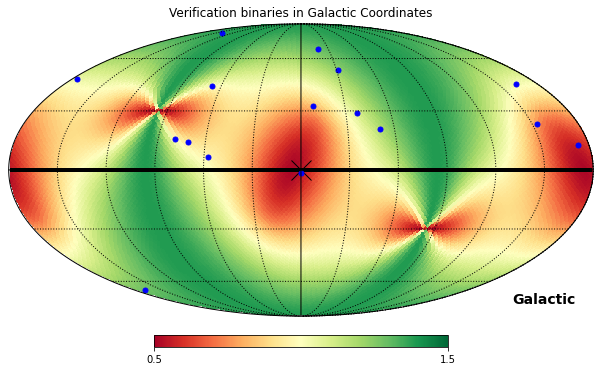

In [7]:
# Galactic coordinates
m = zeros(NPIX)
coords = np.array([hp.pix2ang(NSIDE,k, lonlat=True) for k in arange(NPIX)]).transpose()
c=SkyCoord(coords[0], coords[1], unit='deg', frame='galactic')

for k in arange(NPIX):
   # theta,phi= hp.pix2ang(NSIDE, k)
   # c = SkyCoord(ra=phi, dec=pi/2-theta, frame='icrs', unit='rad')
    m[k]= SignalFromSkyPos(c[k].barycentricmeanecliptic.lon.value*pi/180,c[k].barycentricmeanecliptic.lat.value*pi/180, xi=pi/6, up=True)/sqrt(6/5)
mollviewplot(m,gc_gp_lon,gc_gp_lat,galactic_longitude,galactic_latitude,gpct[0],'G',"Verification binaries in Galactic Coordinates")


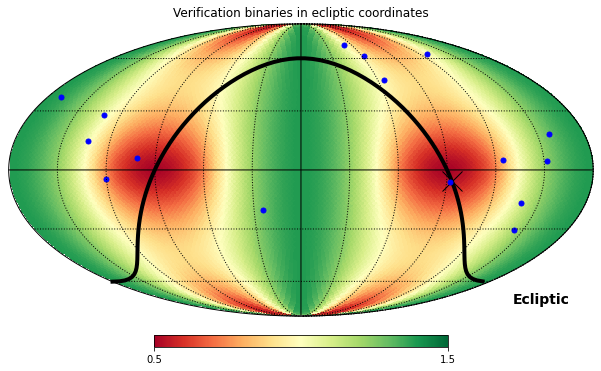

In [8]:
# Ecliptic coordinates
m = zeros(NPIX)
for k in arange(NPIX):
    theta,phi= hp.pix2ang(NSIDE, k)
    m[k]= SignalFromSkyPos(phi,theta, xi=0, up=True)/sqrt(6/5)
mollviewplot(m,gp_beta,gp_lambda,np.rad2deg(gw_beta_true),np.rad2deg(gw_lambda_true),gpct[1],'E',"Verification binaries in ecliptic coordinates")

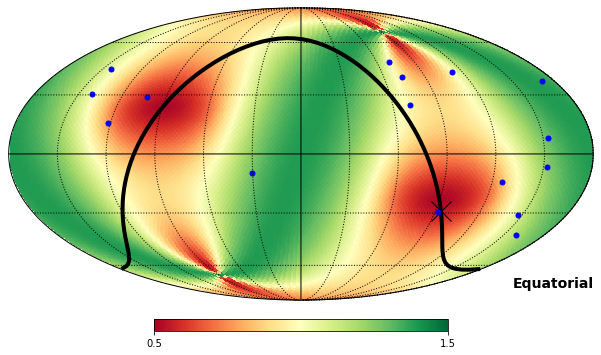

In [15]:
# Equatoral coordinates
# m = zeros(NPIX)
# coords = np.array([hp.pix2ang(NSIDE,k, lonlat=True) for k in arange(NPIX)]).transpose()
# c=SkyCoord(coords[0], coords[1], unit='deg', frame='icrs')
# for k in arange(NPIX):
#    # theta,phi= hp.pix2ang(NSIDE, k)
#    # c = SkyCoord(ra=phi, dec=pi/2-theta, frame='icrs', unit='rad')
#     m[k]= SignalFromSkyPos(c[k].barycentricmeanecliptic.lon.value*pi/180,c[k].barycentricmeanecliptic.lat.value*pi/180, xi=0, up=True)/sqrt(6/5)


mollviewplot(m,gp_ra,gp_dec,ra,dec,gpct[2],'C',"")#"Verification binaries in Equatoral Coordinates")
plt.savefig("plots/VerBins_AntenPatt_Equatoral.jpg")